In [149]:
# 各种函数库
#coding:utf-8
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')
# 查看当前运行环境
import sys
print("当前运行环境：")
print(sys.executable)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
# 设置不显示科学计数
np.set_printoptions(suppress=True)
# 设置显示全部列
pd.set_option('display.max_columns', None)

当前运行环境：
/home/xyz/anaconda3/envs/ds/bin/python


In [150]:
# 读取数据
# path = "./datalab/231784/"
path = "../dataSet/"
Train_data = pd.read_csv(path+'used_car_train_20200313.csv', sep=' ')
Test_data = pd.read_csv(path+'used_car_testA_20200313.csv', sep=' ')

In [179]:
Test_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,150000,66932,20111212,222.0,4,5.0,1.0,1.0,313,15.0,0.0,1440,0,0,20160329,49.593127,5.246568,1.001130,-4.122264,0.737532,0.264405,0.121800,0.070899,0.106558,0.078867,-7.050969,-0.854626,4.800151,0.620011,-3.664654
1,150001,174960,19990211,19.0,21,0.0,0.0,0.0,75,12.5,1.0,5419,0,0,20160404,42.395926,-3.253950,-1.753754,3.646605,-0.725597,0.261745,0.000000,0.096733,0.013705,0.052383,3.679418,-0.729039,-3.796107,-1.541230,-0.757055
2,150002,5356,20090304,82.0,21,0.0,0.0,0.0,109,7.0,0.0,5045,0,0,20160308,45.841370,4.704178,0.155391,-1.118443,-0.229160,0.260216,0.112081,0.078082,0.062078,0.050540,-4.926690,1.001106,0.826562,0.138226,0.754033
3,150003,50688,20100405,0.0,0,0.0,0.0,1.0,160,7.0,0.0,4023,0,0,20160325,46.440649,4.319155,0.428897,-2.037916,-0.234757,0.260466,0.106727,0.081146,0.075971,0.048268,-4.864637,0.505493,1.870379,0.366038,1.312775
4,150004,161428,19970703,26.0,14,2.0,0.0,0.0,75,15.0,0.0,3103,0,0,20160309,42.184604,-3.166234,-1.572058,2.604143,0.387498,0.250999,0.000000,0.077806,0.028600,0.081709,3.616475,-0.673236,-3.197685,-0.025678,-0.101290


In [151]:
# 这里我包装了一个异常值处理的代码，可以随便调用。
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


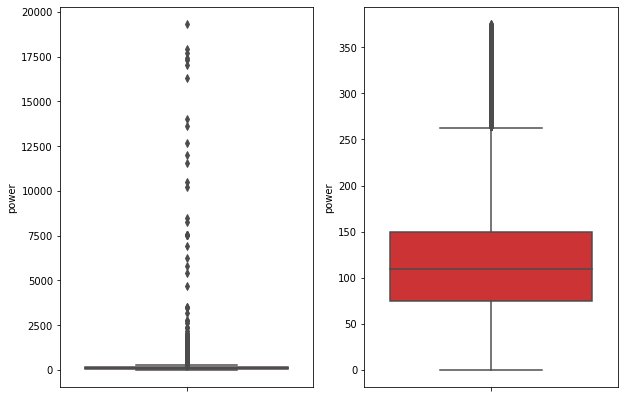

In [152]:
# 我们可以删掉一些异常数据，以 power 为例。  
# 这里删不删同学可以自行判断
# 但是要注意 test 的数据不能删 = = 不能掩耳盗铃是不是

Train_data = outliers_proc(Train_data, 'power', scale=3)

In [154]:
# 训练集和测试集放在一起，方便构造特征
# Train_data['train']=1
# Test_data['train']=0
# data = pd.concat([Train_data, Test_data], ignore_index=True)
data = Train_data

In [155]:
# 使用时间：data['creatDate'] - data['regDate']，反应汽车使用时间，一般来说价格与使用时间成反比
# 不过要注意，数据里有时间出错的格式，所以我们需要 errors='coerce'
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [156]:
# 看一下空数据，有 15k 个样本的时间是有问题的，我们可以选择删除，也可以选择放着。
# 但是这里不建议删除，因为删除缺失数据占总样本量过大，7.5%
# 我们可以先放着，因为如果我们 XGBoost 之类的决策树，其本身就能处理缺失值，所以可以不用管；
data['used_time'].isnull().sum()

11318

In [157]:
# 从邮编中提取城市信息，相当于加入了先验知识
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])
data = data

In [158]:
# 计算某品牌的销售统计量，同学们还可以计算其他特征的统计量
# 这里要以 train 的数据计算统计量
Train_gb = Train_data.groupby("brand")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')

In [159]:
# 数据分桶 以 power 为例
# 这时候我们的缺失值也进桶了，
# 为什么要做数据分桶呢，原因有很多，= =
# 1. 离散后稀疏向量内积乘法运算速度更快，计算结果也方便存储，容易扩展；
# 2. 离散后的特征对异常值更具鲁棒性，如 age>30 为 1 否则为 0，对于年龄为 200 的也不会对模型造成很大的干扰；
# 3. LR 属于广义线性模型，表达能力有限，经过离散化后，每个变量有单独的权重，这相当于引入了非线性，能够提升模型的表达能力，加大拟合；
# 4. 离散后特征可以进行特征交叉，提升表达能力，由 M+N 个变量编程 M*N 个变量，进一步引入非线形，提升了表达能力；
# 5. 特征离散后模型更稳定，如用户年龄区间，不会因为用户年龄长了一岁就变化

# 当然还有很多原因，LightGBM 在改进 XGBoost 时就增加了数据分桶，增强了模型的泛化性

bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [160]:
# 删除不需要的数据
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

In [161]:
print(data.shape)
data.columns

(149037, 38)


Index(['SaleID', 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'seller', 'offerType',
       'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
       'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'used_time', 'city',
       'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')

In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149037 entries, 0 to 149036
Data columns (total 38 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   SaleID               149037 non-null  int64  
 1   name                 149037 non-null  int64  
 2   model                149036 non-null  float64
 3   brand                149037 non-null  int64  
 4   bodyType             144543 non-null  float64
 5   fuelType             140405 non-null  float64
 6   gearbox              143083 non-null  float64
 7   power                149037 non-null  int64  
 8   kilometer            149037 non-null  float64
 9   notRepairedDamage    149037 non-null  object 
 10  seller               149037 non-null  int64  
 11  offerType            149037 non-null  int64  
 12  price                149037 non-null  int64  
 13  v_0                  149037 non-null  float64
 14  v_1                  149037 non-null  float64
 15  v_2              

In [163]:
data.head()

,SaleID,name,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,seller,offerType,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,0,736,30.0,6,1.0,0.0,0.0,60,12.5,0.0,0,0,1850,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,4385.0,1,10193.0,35990.0,1800.0,13.0,36457518.0,4562.233331,3576.37,5.0
1,1,2262,40.0,1,2.0,0.0,0.0,0,15.0,-,0,0,3600,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,4757.0,4,13656.0,84000.0,6399.0,15.0,124044603.0,8988.865406,9082.86,NaN
2,2,14874,115.0,15,1.0,0.0,0.0,163,12.5,0.0,0,0,6222,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,4382.0,2,1458.0,45000.0,8500.0,100.0,14373814.0,5425.058140,9851.83,16.0
3,3,71865,109.0,10,0.0,0.0,1.0,193,15.0,0.0,0,0,2400,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,7125.0,,13994.0,92900.0,5200.0,15.0,113034210.0,8244.695287,8076.76,19.0
4,4,111080,110.0,5,1.0,0.0,0.0,68,5.0,0.0,0,0,5200,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,1531.0,6,4662.0,31500.0,2300.0,20.0,15414322.0,3344.689763,3305.67,6.0


模型

In [164]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [165]:
sample_feature = reduce_mem_usage(data)

Memory usage of dataframe is 46499544.00 MB
Memory usage after optimization is: 13264789.00 MB
Decreased by 71.5%


In [166]:
sample_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149037 entries, 0 to 149036
Data columns (total 38 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   SaleID               149037 non-null  int32   
 1   name                 149037 non-null  int32   
 2   model                149036 non-null  float16 
 3   brand                149037 non-null  int8    
 4   bodyType             144543 non-null  float16 
 5   fuelType             140405 non-null  float16 
 6   gearbox              143083 non-null  float16 
 7   power                149037 non-null  int16   
 8   kilometer            149037 non-null  float16 
 9   notRepairedDamage    149037 non-null  category
 10  seller               149037 non-null  int8    
 11  offerType            149037 non-null  int8    
 12  price                149037 non-null  int32   
 13  v_0                  149037 non-null  float16 
 14  v_1                  149037 non-null  float16 
 15  

In [167]:
sample_feature.columns

Index(['SaleID', 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'seller', 'offerType',
       'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
       'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'used_time', 'city',
       'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')

In [168]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model']]
continuous_feature_names

['SaleID',
 'name',
 'bodyType',
 'fuelType',
 'gearbox',
 'power',
 'kilometer',
 'notRepairedDamage',
 'seller',
 'offerType',
 'v_0',
 'v_1',
 'v_2',
 'v_3',
 'v_4',
 'v_5',
 'v_6',
 'v_7',
 'v_8',
 'v_9',
 'v_10',
 'v_11',
 'v_12',
 'v_13',
 'v_14',
 'used_time',
 'city',
 'brand_amount',
 'brand_price_max',
 'brand_price_median',
 'brand_price_min',
 'brand_price_sum',
 'brand_price_std',
 'brand_price_average',
 'power_bin']

In [169]:
sample_feature = sample_feature.dropna().replace('-', 0).replace('', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
sample_feature['city'] = sample_feature['city'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

In [180]:
train_X.head()

,SaleID,name,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,seller,offerType,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,0,736,1.0,0.0,0.0,60,12.5,0.0,0,0,43.34375,3.966797,0.050262,2.160156,1.143555,0.235718,0.101990,0.129517,0.022812,0.097473,-2.880859,2.804688,-2.419922,0.795410,0.914551,4384.0,1.0,10192.0,35990.0,1800.0,13.0,36457520.0,4564.0,3576.0,5.0
1,2,14874,1.0,0.0,0.0,163,12.5,0.0,0,0,45.96875,4.824219,1.319336,-0.998535,-0.997070,0.251465,0.114929,0.165161,0.062164,0.027069,-4.847656,1.803711,1.565430,-0.832520,-0.229980,4384.0,2.0,1458.0,45000.0,8496.0,100.0,14373814.0,5424.0,9848.0,16.0
2,3,71865,0.0,0.0,1.0,193,15.0,0.0,0,0,45.68750,4.492188,-0.050629,0.883789,-2.228516,0.274414,0.110291,0.121948,0.033386,0.000000,-4.507812,1.286133,-0.501953,-2.437500,-0.478760,7124.0,0.0,13992.0,92900.0,5200.0,15.0,113034208.0,8248.0,8076.0,19.0
3,4,111080,1.0,0.0,0.0,68,5.0,0.0,0,0,44.37500,2.031250,0.572266,-1.571289,2.246094,0.228027,0.073181,0.091858,0.078796,0.121521,-1.896484,0.910645,0.931152,2.833984,1.923828,1531.0,6.0,4664.0,31500.0,2300.0,20.0,15414322.0,3344.0,3306.0,6.0
4,5,137642,0.0,1.0,0.0,109,10.0,0.0,0,0,46.31250,-3.228516,0.156616,-1.727539,-0.345703,0.260254,0.000518,0.119812,0.090942,0.048767,1.885742,-2.722656,2.457031,-0.286865,0.206543,2482.0,3.0,13992.0,92900.0,5200.0,15.0,113034208.0,8248.0,8076.0,10.0


In [171]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)

In [172]:
model = model.fit(train_X, train_y)

In [174]:
train_y_ln = np.log(train_y + 1)

In [175]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [176]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [177]:
print('AVG:', np.mean(scores))

AVG: 1.3510727299362533


In [184]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))
print('处理过标签AVG:', np.mean(scores))
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
处理过标签AVG: 0.19192516238888455
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


,cv1,cv2,cv3,cv4,cv5
MAE,0.190716,0.192179,0.192826,0.190973,0.192932


In [182]:
print('intercept:'+ str(model.intercept_) )
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:-135434.92126221542


[('v_6', 3450165.502866205),
 ('v_8', 693061.9053597566),
 ('v_9', 197574.85007642512),
 ('v_12', 27492.250559818072),
 ('v_7', 25633.934902944042),
 ('v_3', 21030.88008812915),
 ('v_11', 15070.87347583437),
 ('v_13', 11845.784695022785),
 ('v_10', 6717.157531159483),
 ('gearbox', 817.6642396157627),
 ('fuelType', 318.53997472853706),
 ('bodyType', 191.375706551013),
 ('city', 44.3959988087887),
 ('power', 26.41286145858343),
 ('brand_price_median', 0.5252869312540315),
 ('brand_price_std', 0.4480475547959458),
 ('brand_amount', 0.144080457717933),
 ('used_time', 0.023286408762533184),
 ('brand_price_max', 0.004457166740471116),
 ('SaleID', 5.35074183479725e-05),
 ('offerType', -1.3066455721855164e-06),
 ('seller', -4.996312782168388e-06),
 ('brand_price_sum', -2.1166902723224175e-05),
 ('name', -0.00013941267399601986),
 ('brand_price_average', -0.4291713932998089),
 ('brand_price_min', -2.270449003108827),
 ('power_bin', -17.74123012495243),
 ('v_14', -209.8809006508486),
 ('kilomete

In [185]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso 
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [188]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [189]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190716,0.194590,0.382130
cv2,0.192179,0.195980,0.379197
cv3,0.192826,0.196652,0.382811
cv4,0.190973,0.195019,0.378890
cv5,0.192932,0.196765,0.381933
